In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Загрузка
news = pd.read_csv('C:/Users/makbu/OneDrive/Desktop/hak/data/news.csv')
candles = pd.read_csv('C:/Users/makbu/OneDrive/Desktop/hak/data/candles.csv')

print(f"\nНовости: {len(news)} строк")
print(f"Котировки: {len(candles)} строк")

print("\nКолонки новостей:")
print(news.columns.tolist())

print("\nТипы данных:")
print(news.dtypes)

print("\nПропуски:")
print(news.isnull().sum())

print("\nПервые 3 новости:")
for i in range(3):
    print(f"\n--- Новость {i+1} ---")
    print(f"Дата: {news.iloc[i]['publish_date']}")
    print(f"Заголовок: {news.iloc[i]['title']}")
    print(f"Текст (первые 200 символов): {str(news.iloc[i]['publication'])[:200]}...")

# Распределение по времени
news['publish_date'] = pd.to_datetime(news['publish_date'])
print(f"\nПериод новостей: {news['publish_date'].min()} - {news['publish_date'].max()}")

# Количество новостей по месяцам
news['month'] = news['publish_date'].dt.to_period('M')
print("\nНовостей по месяцам:")
print(news['month'].value_counts().sort_index())

# Тикеры в котировках
print("\nТикеры в котировках:")
print(candles['ticker'].unique())
print(f"Всего уникальных тикеров: {candles['ticker'].nunique()}")


Новости: 25425 строк
Котировки: 24197 строк

Колонки новостей:
['Unnamed: 0', 'publish_date', 'title', 'publication']

Типы данных:
Unnamed: 0       int64
publish_date    object
title           object
publication     object
dtype: object

Пропуски:
Unnamed: 0      0
publish_date    0
title           0
publication     0
dtype: int64

Первые 3 новости:

--- Новость 1 ---
Дата: 2020-01-01 14:00:00
Заголовок: Ключевые российские нефтегазовые компании смотрятся выгодно относительно аналогов
Текст (первые 200 символов): Тенденции в отрасли. Ключевые российские нефтегазовые компании смотрятся выгодно относительно аналогов с развитых и развивающихся рынков как на операционном, так и на финансовом уровнях. Можно отметит...

--- Новость 2 ---
Дата: 2020-01-02 15:00:00
Заголовок: ММК выгодно отличает высокая экспозиция на внутренний рынок
Текст (первые 200 символов): Тенденции в отрасли. Ключевые российские сталелитейные компании сохраняют конкурентоспособность на операционном и финансовом уровн

Найдено дивидендных новостей: 2935
После удаления дивидендов осталось: 22490 новостей
Удаляем 695 новостей за период 2020-03-01 - 2020-05-01
Удаляем 735 новостей за период 2022-02-24 - 2022-04-01
Удаляем 4 новостей за период 2023-06-23 - 2023-06-25
Удаляем 5 новостей за период 2023-03-10 - 2023-03-12
Удаляем 0 новостей за период 2023-10-07 - 2023-10-8

Новостей по месяцам:
year_month
2020-01    277
2020-02    456
2020-05    315
2020-06    377
2020-07    457
2020-08    399
2020-09    403
2020-10    401
2020-11    389
2020-12    454
2021-01    276
2021-02    477
2021-03    514
2021-04    629
2021-05    534
2021-06    595
2021-07    622
2021-08    579
2021-09    655
2021-10    667
Freq: M, Name: count, dtype: int64


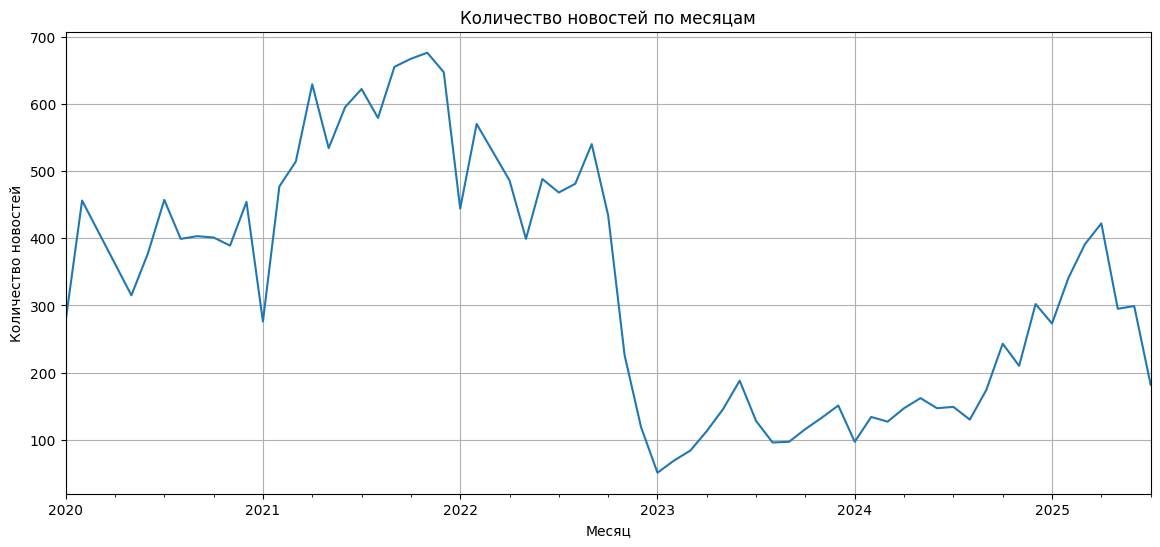

In [2]:
# Удаляем экстремальные периоды (лебедей)
black_swan_periods = [
    ('2020-03-01', '2020-05-01'),  # COVID паника
    ('2022-02-24', '2022-04-01'),  # начало СВО
    ('2023-06-23', '2023-06-25'),  # путч
    ('2023-03-10', '2023-03-12'),  # крах silicon valley bank
    ('2023-10-07', '2023-10-8'),   # израиль-хамас 
]

# Ключевые слова для дивидендов
dividend_keywords = [
    'дивиденд', 'dividend', 'выплат', 'дивы', 
    'реестр акционеров', 'отсечка', 'экс-дивидендная дата'
]

def is_dividend_news(text):
    if pd.isna(text):
        return False
    text_lower = str(text).lower()
    return any(kw in text_lower for kw in dividend_keywords)

# Помечаем дивидендные новости
news['is_dividend'] = news['title'].apply(is_dividend_news)

print(f"Найдено дивидендных новостей: {news['is_dividend'].sum()}")

# Убираем их ДО финального объединения тикеров
news = news[~news['is_dividend']].copy()

print(f"После удаления дивидендов осталось: {len(news)} новостей")


for start, end in black_swan_periods:
    mask = (news['publish_date'] >= start) & (news['publish_date'] <= end)
    print(f"Удаляем {mask.sum()} новостей за период {start} - {end}")
    news = news[~mask]
# Конвертируем в datetime
news['publish_date'] = pd.to_datetime(news['publish_date'])

# Группируем по месяцам
news['year_month'] = news['publish_date'].dt.to_period('M')
monthly_counts = news['year_month'].value_counts().sort_index()

print("\nНовостей по месяцам:")
print(monthly_counts.head(20))

# График
import matplotlib.pyplot as plt
monthly_counts.plot(kind='line', figsize=(14, 6))
plt.title('Количество новостей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество новостей')
plt.grid(True)
plt.show()

In [7]:
# Создаем словарь тикеров
ticker_names = {
    'SBER': ['сбербанк', 'сбер', 'sberbank', 'sber', 'сбера', 'греф', 'сберу', 'сбербанку', 'сбербанка', 'сбербанке', 'сбере'],
    
    'GAZP': ['GAZP', 'газпром', 'gazprom', 'ogzpy', 'газпрома', 'миллер', 'газпрому', 'газпроме'],
    
    'LKOH': ['LKOH', 'лукойл', 'lukoil', 'lukoy', 'лукойла', 'воробьев', 'воробьёв', 'лукойлу', 'лукойле'],
    
    'GMKN': ['GMKN', 'норникель', 'норильский никель', 'norilsk', 'норильск', 'gmk', 'горно-металлургическая', 'потанин','норникелю', 'норильскому никелю', 'норникеля'],
    
    'NVTK': ['NVTK', 'новатэк', 'novatek', 'новатэка', 'новатека', 'михельсон', 'новатэку', 'новатеку', 'спг', 'природный газ'],
    
    'ROSN': ['ROSN', 'роснефть', 'rosneft', 'игорь сечин', 'сечин','роснефти'], 
    
    'VTBR': ['VTBR', 'втб', 'vtb', 'внешторгбанк', 'костин', 'группа втб'], 
    
    'MTSS': ['MTSS', 'мтс', 'mts', 'мобильные телесистемы', 'mobile telesystems', 'афк система', 'мтс-банк', 'мтс банк', 'мтс медиа', 'юрент'],
    
    'MAGN': ['MAGN', 'магнитогорский', 'ммк', 'magnitogorsk', 'рашников', 'mmk', 'магнитогорск'],

    'ALRS': ['ALRS', 'алроса', 'alrosa', 'алмазы', 'алмазная', 'маринычев', 'алросе', 'бриллианты', 'якутия'],
    
    'PLZL': ['PLZL', 'полюс', 'polyus', 'золото', 'полюс золото', 'сулейман', 'керимов','полюсу', 'месторождение', 'золота', 'золоту'],
    
    'CHMF': ['CHMF', 'северсталь', 'severstal', 'мордашов'],  
    
    'MOEX': ['MOEX', 'мосбиржа', 'московская биржа', 'moex', 'мск биржа', 'жидков', 'нкц', 'национальный клиринговый центр', 'национальный расчетный депозитарий', 'нрд'],
    
    'PHOR': ['PHOR', 'фосагро', 'phosagro', 'удобрения', 'гильгенберг', 'фосфаты', 'апатиты'],
    
    'RUAL': ['RUAL', 'русал', 'rusal', 'алюминий', 'дерипаска', 'rual'],  
    
    'AFLT': ['AFLT', 'аэрофлот', 'aeroflot', 'авиакомпания', 'савельев', 'победа', 'аэрофлоту'], 
    
    'T': ['тинькофф', 'tinkoff', 'тиньков', 'tcs', 'ткс групп', 'тиньк', 'тбанк', 'т-банк', 'tcs group', 'tcs group holding PLC','тбанку','т-банку', 'тинькову', 'тинькоффу', 'tbank', 'Т', 'олег тиньков'],
    
    'MDMG': ['md medical', 'мд медикал', 'md medical group', 'мд', 'медикал групп'],
    
    'GEMC': ['юнайтед медикал груп', 'юнайтед медикал групп'],
    
    'VKCO': ['vk', 'вконтакте', 'vk company', 'вк', 'одноклассники', 'мэйл ру', 'mail.ru', 'кириенко'],
    
    'LENT': ['лента', 'lenta', 'ритейл', 'продуктовая сеть', 'ленте', 'ленты'],
    
    'HEAD': ['headhunter', 'хедхантер', 'hh', 'hh.ru', 'хх', 'работа', 'вакансии'],
    
    'CNRU': ['циан', 'cian', 'циану', 'циана', 'циане', 'недвижимость онлайн', 'платформа недвижимости', 'аренда квартир', 'продажа квартир', 'объявления недвижимость'],
    
    'ENPG': ['эн+ групп', 'en+ group', 'эн плюс', 'дерипаска', 'енисейская генерация'],
    
    'YDEX': ['яндекс', 'yandex', 'яндексу', 'яндекса', 'яндекс такси', 'яндекс маркет', 'яндекс еда'],
    
    'BSPB': ['банк санкт-петербург', 'бспб', 'спб банк', 'банк спб'],
    
    'AQUA': ['инарктика', 'inarctica', 'инарктику', 'инарктики', 'инарктике', 'арктика', 'северная логистика', 'арктическая логистика', 'северный завоз', 'снабжение арктика'],
    
    'AFKS': ['афк система', 'sistema', 'система', 'евтушенков', 'мтс афк'],
    
    'VSEH': ['все инструменты', 'всеинструменты', 'всеинструменты.ру', 'vseins', 'vse instrumenty', 'инструменты ру', 'все инструменты ру', 'строительные инструменты', 'онлайн инструменты', 'маркетплейс инструментов'],
    
    'RAGR': ['русагро', 'rusagro', 'aqua', 'агрохолдинг', 'сахар', 'мясо', 'свинина', 'басов', 'русагру', 'русагра', 'русагре', 'агрокомпания', 'сахарный завод', 'свиноводство', 'мясопереработка', 'масложировой', 'растениеводство', 'русский агро', 'вадим мошкович', 'мошкович'],
    
    'LSRG': ['лср', 'lsr', 'строительная', 'недвижимость', 'девелопмент', 'молчанов'],
    
    'POSI': ['positive technologies', 'позитив технолоджис', 'позитив', 'кибербезопасность', 'it безопасность'],
    
    'RENI': ['ренессанс страхование', 'ренессанс', 'страховая'],
    
    'EUTR': ['евротранс', 'eurotrans', 'грузоперевозки', 'логистика'],
    
    'IRAO': ['интер рао', 'inter rao', 'энергетика', 'электроэнергия', 'интеррао', 'ковальчук'],
    
    'X5': ['x5', 'икс 5', 'пятерочка', 'перекресток', 'карусель', 'ритейл', 'х5'],
    
    'LEAS': ['европлан', 'europlan', 'лизинг', 'автолизинг'],
    
    'MVID': ['м.видео', 'мвидео', 'mvideo', 'эльдорадо', 'техника', 'электроника'],
    
    'MBNK': ['мтс-банк','мтс банк', 'мтс', 'дочка мтс', 'дочерняя компаниия мтс','"дочка" мтс'],
    
    'MTLR': ['мечел', 'mechel', 'металлургия', 'уголь', 'зюзин'],
    
    'BELU': ['новабев групп', 'новабев', 'белуга', 'белуга групп', 'beluga', 'алкоголь', 'водка'],
    
    'NLMK': ['нлмк', 'новолипецкий', 'nlmk', 'липецк', 'лисин', 'металлургический комбинат'],
    
    'PIKK': ['пик', 'pik', 'девелопер', 'недвижимость', 'строительная', 'пику'],
    
    'RTKM': ['ростелеком', 'rostelecom', 'ртк', 'телеком', 'оператор связи'],
    
    'SELG': ['селигдар', 'seligdar', 'золотодобыча', 'золото', 'якутия'],
    
    'SVCB': ['совкомбанк', 'sovcombank', 'совком', 'банк'],
    
    'FLOT': ['совкомфлот', 'sovcomflot', 'танкеры', 'морские перевозки', 'нефтяные танкеры'],
    
    'TGKA': ['тгк-1', 'территориальная генерирующая компания', 'тэц', 'электростанция', 'энергетика'],
    
    'HYDR': ['русгидро', 'rushydro', 'гидроэлектростанция', 'гэс', 'энергетика', 'шульгинов'],
    
    'FEES': ['россети', 'россеть', 'фск еэс', 'федеральная сетевая компания', 'сетевая компания', 'электросети', 'энергосистема'],
    
    'FIXR': ['fix price', 'фикс прайс', 'фикспрайс', 'ритейл', 'кирсанов'],
    
    'ELFV': ['эл5-энерго', 'эл5', 'электроэнергия', 'энергосбыт'],
    
    'SFIN': ['сфи', 'sfin', 'эсэфай', 'эс-эф-ай', 's.f.i.', 'специализированный финансовый институт', 'ипотека', 'ипотечный', 'жилищное финансирование', 'сфи банк', 'сфи ипотека', 'специализированная финансовая институция'],
    
    'UPRO': ['юнипро', 'unipro', 'электростанции', 'тэц', 'энергогенерация'],
    
    'ASTR': ['астра', 'astra', 'операционная система', 'российская ос', 'линукс'],
    
    'SGZH': ['сегежа', 'segezha', 'целлюлоза', 'бумага', 'лесопереработка', 'впк'],
    
    'RNFT': ['русснефть', 'russneft', 'нефтяная', 'нефтедобыча', 'гуцериев'],
    
    'MSNG': ['мосэнерго', 'mosenergo', 'тэц', 'москва энергетика', 'московская энергетика'],
    
    'SMLT': ['самолет', 'группа самолет', 'samolet', 'девелопер', 'недвижимость', 'строительная'],
    
    'TATN': ['татнефть', 'tatneft', 'нефть татарстан', 'нефтяная', 'маганов'],
    
    'ETLN': ['эталон', 'etalon', 'девелопер', 'недвижимость', 'строительная'],
    
    'PRMD': ['промомед', 'promomed', 'медицина', 'клиники'],
    
    'HNFG': ['henderson', 'хэндерсон', 'хендерсон', 'мужской одежды', 'мужская одежда'],
    
    'AKRN': ['акрон', 'akron', 'удобрения', 'химическая промышленность', 'азот'],
    
    'APTK': ['аптеки 36,6', 'аптека 36.6', 'фармацевтика', 'аптечная сеть'],
    
    'ABIO': ['артген', 'artgen', 'биотехнологии', 'медицина', 'биотех'],
    
    'WUSH': ['whoosh', 'вуш', 'кикшеринг'],
    
    'OGKB': ['огк-2', 'вторая генерирующая компания', 'электростанции', 'тэс', 'ogkb'],
    
    'DATA': ['аренадата', 'arenadata'],
    
    'FESH': ['двмп', 'дальневосточное морское пароходство', 'двмп приморье', 'контейнерные перевозки'],
    
    'DIAS': ['диасофт', 'diasoft', 'it', 'софт для банков', 'банковское по'],
    
    'IVAT': ['iva', 'iva technologies', 'ива технологии', 'ivat'],
    
    'KMAZ': ['камаз', 'kamaz', 'грузовики', 'автопром', 'коголко'],
    
    'DELI': ['группа позитив', 'deli', 'кибербезопасность', 'it'],
    
    'OZPH': ['озон фармацевтика', 'ozon pharma', 'аптеки', 'фармацевтика'],
    
    'RASP': ['распадская', 'raspadskaya', 'уголь', 'угольная', 'кузбасс', 'евраз'],
    
    'MRKV': ['мрск волги', 'волжская сетевая', 'электросети', 'энергетика'],
    
    'MSRS': ['россети московский регион', 'моэск', 'московская объединенная электросетевая', 'электросети москвы'],
    
    'MRKZ': ['мрск сибири', 'сибирская сетевая', 'электросети сибирь'],
    
    'MRKU': ['мрск урала', 'уральская сетевая', 'электросети урал'],
    
    'MRKP': ['мрск северо-запада', 'северо-западная сетевая', 'электросети'],
    
    'MRKC': ['россети центр', 'мрск центра', 'центральная сетевая', 'электросети центр'],
    
    'SVAV': ['соллерс', 'sollers', 'автопром', 'автомобили', 'уаз', 'шепелев'],
    
    'SOFL': ['софтлайн', 'softline', 'it', 'дистрибуция по', 'софт'],
    
    'SNGS': ['сургутнефтегаз', 'surgutneftegaz', 'сургутнефть', 'нефтяная', 'богданов'],
    
    'TGKN': ['тгк-14', 'территориальная генерирующая 14', 'энергетика', 'тэц'],
    
    'TRMK': ['тмк', 'трубная металлургическая компания', 'tmk', 'пумпянский'],
    
    'UGLD': ['южуралзолото', 'ugold', 'золотодобыча', 'южный урал'],
    
    'VSMO': ['всмпо-ависма', 'vsmpo-avisma', 'титан', 'металлургия', 'авиация'],
    
    'YDEX': ['яндекс', 'yandex'],
    
    'OZON': ['ozon', 'озон', 'вайлдбериз', 'маркетплейс']
    

}

# Функция поиска
def find_tickers_in_text(text):
    if pd.isna(text):
        return []
    text_lower = str(text).lower()
    found = []
    for ticker, names in ticker_names.items():
        if any(name in text_lower for name in names):
            found.append(ticker)
    return found

# Ищем в заголовках и текстах
news['found_in_title'] = news['title'].apply(find_tickers_in_text)
news['found_in_text'] = news['publication'].apply(find_tickers_in_text)

# Объединяем (берем из заголовка, если есть, иначе из текста)
news['matched_tickers'] = news.apply(
    lambda row: row['found_in_title'] if len(row['found_in_title']) > 0 else row['found_in_text'],
    axis=1
)

# Статистика
news['has_ticker'] = news['matched_tickers'].apply(lambda x: len(x) > 0)
print(f"\nНовостей с найденными тикерами: {news['has_ticker'].sum()} ({news['has_ticker'].mean()*100:.1f}%)")
print(f"Новостей без тикеров: {(~news['has_ticker']).sum()}")

# Распределение по тикерам
from collections import Counter
all_tickers = [ticker for tickers in news['matched_tickers'] for ticker in tickers]
ticker_counts = Counter(all_tickers)
print("\nУпоминаемость компаний:")
for ticker, count in ticker_counts.most_common(91):
    print(f"{ticker}: {count} новостей")


Новостей с найденными тикерами: 20504 (97.4%)
Новостей без тикеров: 547

Упоминаемость компаний:
VKCO: 4606 новостей
GAZP: 4371 новостей
SVCB: 3110 новостей
SBER: 2532 новостей
VTBR: 2459 новостей
MOEX: 2115 новостей
DELI: 1610 новостей
SOFL: 1602 новостей
DIAS: 1589 новостей
POSI: 1574 новостей
LKOH: 1434 новостей
PLZL: 1427 новостей
GMKN: 1323 новостей
ROSN: 1295 новостей
NVTK: 1290 новостей
HEAD: 1147 новостей
AFLT: 1059 новостей
YDEX: 1036 новостей
RUAL: 990 новостей
SGZH: 930 новостей
ALRS: 885 новостей
MAGN: 786 новостей
MTSS: 778 новостей
MBNK: 755 новостей
SELG: 750 новостей
PHOR: 730 новостей
PIKK: 673 новостей
CHMF: 594 новостей
RTKM: 592 новостей
X5: 529 новостей
MTLR: 458 новостей
LENT: 446 новостей
OZON: 435 новостей
NLMK: 429 новостей
FIXR: 373 новостей
T: 367 новостей
SNGS: 342 новостей
SMLT: 305 новостей
AKRN: 299 новостей
AFKS: 283 новостей
RASP: 280 новостей
TATN: 215 новостей
HYDR: 213 новостей
ETLN: 198 новостей
LSRG: 168 новостей
TGKA: 149 новостей
IRAO: 147 новос

In [10]:
# Маппинг тикеров (твой код без изменений)
news['matched_tickers'] = news.apply(
    lambda row: row['found_in_title'] if len(row['found_in_title']) > 0 else row['found_in_text'],
    axis=1
)
news['has_ticker'] = news['matched_tickers'].apply(lambda x: len(x) > 0)

# Общерыночные ключевые слова
market_keywords = [
    'ставка цб', 'ключевая ставка', 'центробанк', 'набиуллина',
    'санкции', 'санкций', 'санкционн',
    'курс рубля', 'рубль', 'доллар', 'валют',
    'инфляция', 'инфляционное',
    'индекс мосбиржи', 'ммвб',
    'brent', 'брент', 'urals', 'опек', 'опек+',
    'цены на энергоносители'
]

def has_market_news(text):
    if pd.isna(text):
        return False
    text_lower = str(text).lower()
    return any(kw in text_lower for kw in market_keywords)

news['is_market_wide'] = news['publication'].apply(has_market_news)

# Статистика
print(f"Всего новостей: {len(news)}")
print(f"С найденными тикерами (has_ticker): {news['has_ticker'].sum()}")
print(f"Общерыночных (is_market_wide): {news['is_market_wide'].sum()}")

# НОВАЯ ЛОГИКА:
# 1. Общерыночные новости БЕЗ упоминания компаний → тикер MARKET
# 2. Общерыночные С упоминанием компаний → MARKET + дубликаты для компаний
# 3. Компанейские новости → только компанейские тикеры

results = []

for idx, row in news.iterrows():
    is_market = row['is_market_wide']
    company_tickers = row['matched_tickers']

    if is_market:
        # Всегда добавляем MARKET для общерыночных
        results.append({
            'title': row['title'],
            'publication': row['publication'],
            'publish_date': row['publish_date'],
            'ticker': 'MARKET',
            'news_type': 'market_wide'
        })

        # Если есть упоминания компаний - дублируем для них
        if len(company_tickers) > 0:
            for ticker in company_tickers:
                results.append({
                    'title': row['title'],
                    'publication': row['publication'],
                    'publish_date': row['publish_date'],
                    'ticker': ticker,
                    'news_type': 'market_wide_company'
                })
    else:
        # Обычные компанейские новости
        if len(company_tickers) > 0:
            for ticker in company_tickers:
                results.append({
                    'title': row['title'],
                    'publication': row['publication'],
                    'publish_date': row['publish_date'],
                    'ticker': ticker,
                    'news_type': 'company_specific'
                })

news_for_llm = pd.DataFrame(results).sort_values('publish_date').reset_index(drop=True)

print(f"\nИТОГО:")
print(f"MARKET (общерыночные без компаний): {(news_for_llm['ticker'] == 'MARKET').sum()}")
print(f"Общерыночные с упоминанием компаний: {(news_for_llm['news_type'] == 'market_wide_company').sum()}")
print(f"Компанейские: {(news_for_llm['news_type'] == 'company_specific').sum()}")
print(f"ВСЕГО: {len(news_for_llm)}")

print(f"\nРаспределение по тикерам:")
print(news_for_llm['ticker'].value_counts().sort_index())

news_for_llm.to_csv('new_news_for_llm.csv', index=False)

Всего новостей: 21051
С найденными тикерами (has_ticker): 20504
Общерыночных (is_market_wide): 8307

ИТОГО:
MARKET (общерыночные без компаний): 8307
Общерыночные с упоминанием компаний: 31812
Компанейские: 19936
ВСЕГО: 60055

Распределение по тикерам:
ticker
ABIO      25
AFKS     283
AFLT    1059
AKRN     299
ALRS     885
        ... 
VSMO     108
VTBR    2459
WUSH      47
X5       529
YDEX    1036
Name: count, Length: 89, dtype: int64


In [ ]:
# ============================================
# АНАЛИЗ НОВОСТЕЙ ЧЕРЕЗ OPENROUTER API
# ============================================

import json
import time
import re
import pandas as pd
from openai import OpenAI
from tqdm import tqdm

# Настройки (вставил первый ключ с сайта)
API_KEY = "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"
MODEL = "anthropic/claude-3.5-haiku"

BATCH_SIZE = 10  # Сколько новостей обрабатывать за раз
MAX_TOKENS = 4096  # Максимум токенов на ответ

# Инициализация клиента
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=API_KEY
)

# Промпт для анализа
SYSTEM_PROMPT = """Ты финансовый аналитик. Анализируй новости и определяй их влияние на акции компании.

Для каждой новости определи:
1. **sentiment** (тональность):
   - **-1**: Негативная новость (падение выручки, санкции, убытки, судебные иски, негативные прогнозы)
   - **0**: Нейтральная новость (общая информация без явного влияния на акции)
   - **1**: Позитивная новость (рост прибыли, новые контракты, позитивные прогнозы, дивиденды)

2. **confidence** (уверенность от 0 до 10):
   - **0-3**: Слабое влияние (упоминание в общем контексте, незначительные новости)
   - **4-6**: Умеренное влияние (квартальные отчеты, обычные сделки)
   - **7-10**: Сильное влияние (крупные контракты, санкции, смена руководства, резкие изменения финансовых показателей)

Верни результат СТРОГО в формате JSON массива БЕЗ ПОЯСНЕНИЙ:
[
  {"index": 0, "sentiment": -1, "confidence": 8},
  {"index": 1, "sentiment": 0, "confidence": 3},
  {"index": 2, "sentiment": 1, "confidence": 6}
]"""

def analyze_batch(batch_df):
    """Анализирует батч новостей через API"""
    
    # Формируем промпт с ЛОКАЛЬНЫМИ индексами
    prompt = "Проанализируй следующие новости:\n\n"
    for local_idx, (orig_idx, row) in enumerate(batch_df.iterrows()):
        prompt += f"**Index {local_idx}** | Ticker: {row['ticker']}\n"
        prompt += f"Заголовок: {row['title']}\n"
        prompt += f"Текст: {row['publication'][:500]}...\n\n"
    
    prompt += f"\nВерни ТОЛЬКО JSON массив БЕЗ ПОЯСНЕНИЙ с sentiment и confidence для каждого index (0-{len(batch_df)-1})."
    
    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": prompt}
            ],
            max_tokens=MAX_TOKENS,
            temperature=0.3
        )
        
        result = response.choices[0].message.content
        
        # Парсим JSON
        try:
            # Удаляем markdown блоки
            if "```json" in result:
                result = result.split("```json")[1].split("```")[0].strip()
            elif "```" in result:
                result = result.split("```")[1].split("```")[0].strip()
            
            # Ищем JSON массив через regex
            json_match = re.search(r'\[[\s\S]*\]', result)
            if json_match:
                json_str = json_match.group(0)
                sentiments = json.loads(json_str)
            else:
                sentiments = json.loads(result)
            
            # Проверяем длину результата
            if len(sentiments) != len(batch_df):
                print(f"  ⚠️ Получено {len(sentiments)} результатов вместо {len(batch_df)}")
                # Дополняем пустыми значениями
                while len(sentiments) < len(batch_df):
                    sentiments.append({"sentiment": None, "confidence": None})
            
            usage = response.usage
            return sentiments, usage
            
        except json.JSONDecodeError as e:
            print(f"  ❌ Ошибка парсинга JSON: {e}")
            print(f"  Ответ модели: {result[:200]}...")
            # Возвращаем пустые значения для всего батча
            return [{"sentiment": None, "confidence": None}] * len(batch_df), None
            
    except Exception as e:
        print(f"  ❌ Ошибка API: {e}")
        # Возвращаем пустые значения для всего батча
        return [{"sentiment": None, "confidence": None}] * len(batch_df), None

# ============================================
# ЗАГРУЗКА ДАННЫХ
# ============================================

# Загружаем файл new_news_for_llm.csv
news_df = pd.read_csv('new_news_for_llm.csv')

print(f"🚀 ПОЛНЫЙ ЗАПУСК")
print(f"Всего новостей: {len(news_df)}")
print(f"Модель: {MODEL}")
print(f"Batch size: {BATCH_SIZE}\n")

# Инициализируем колонки заранее
news_df['sentiment'] = None
news_df['confidence'] = None

# Обрабатываем батчами
total_input_tokens = 0
total_output_tokens = 0

for i in range(0, len(news_df), BATCH_SIZE):
    batch = news_df.iloc[i:i+BATCH_SIZE]
    batch_num = i//BATCH_SIZE + 1
    total_batches = (len(news_df)-1)//BATCH_SIZE + 1
    
    print(f"Обработка батча {batch_num}/{total_batches} ({i}-{min(i+BATCH_SIZE, len(news_df))})...")
    
    sentiments, usage = analyze_batch(batch)
    
    # Сохраняем результаты ВСЕГДА (даже при ошибке)
    for local_idx, sent_data in enumerate(sentiments):
        global_idx = i + local_idx
        if global_idx < len(news_df):
            news_df.loc[global_idx, 'sentiment'] = sent_data.get('sentiment')
            news_df.loc[global_idx, 'confidence'] = sent_data.get('confidence')
    
    if usage:
        total_input_tokens += usage.prompt_tokens
        total_output_tokens += usage.completion_tokens
        print(f"  ✓ Успешно. Токены: {usage.prompt_tokens} input / {usage.completion_tokens} output")
    else:
        print(f"  ⚠️ Батч обработан с ошибкой, добавлены пустые значения")
    
    # Сохраняем промежуточный результат после каждого батча
    news_df.to_csv('new_news_for_llm_with_sentiment_TEMP.csv', index=False)
    
    time.sleep(1)  # Задержка между запросами

# ============================================
# РЕЗУЛЬТАТЫ
# ============================================

print(f"\n{'='*60}")
print(f"📊 РЕЗУЛЬТАТЫ")
print(f"{'='*60}")
print(f"Обработано новостей: {len(news_df)}")
print(f"Успешных результатов: {news_df['sentiment'].notna().sum()}")
print(f"Ошибок/пропусков: {news_df['sentiment'].isna().sum()}")

print(f"\nИспользовано токенов:")
print(f"  Input:  {total_input_tokens:,}")
print(f"  Output: {total_output_tokens:,}")
print(f"  TOTAL:  {total_input_tokens + total_output_tokens:,}")

# Подсчет стоимости для Claude Haiku
if total_input_tokens > 0:
    input_cost = (total_input_tokens / 1_000_000) * 0.80
    output_cost = (total_output_tokens / 1_000_000) * 4.00
    total_cost = input_cost + output_cost
    
    print(f"\n💰 СТОИМОСТЬ:")
    print(f"  Input:  ${input_cost:.6f}")
    print(f"  Output: ${output_cost:.6f}")
    print(f"  TOTAL:  ${total_cost:.6f}")

# Статистика
valid_sentiments = news_df[news_df['sentiment'].notna()]
if len(valid_sentiments) > 0:
    print(f"\n📋 Распределение sentiment (успешных):")
    print(valid_sentiments['sentiment'].value_counts().sort_index())
    print(f"\n📊 Средняя уверенность: {valid_sentiments['confidence'].mean():.2f}")
    
    # Примеры
    print(f"\n📰 Примеры результатов:")
    for idx, row in valid_sentiments.head(5).iterrows():
        if row['sentiment'] == 1:
            sent = "📈 ПОЗИТИВ"
        elif row['sentiment'] == -1:
            sent = "📉 НЕГАТИВ"
        else:
            sent = "➖ НЕЙТРАЛЬНО"
        
        print(f"\n{sent} (уверенность: {row['confidence']}/10) | {row['ticker']}")
        print(f"  {row['title'][:100]}...")

# Финальное сохранение
news_df.to_csv('new_news_for_llm_with_sentiment.csv', index=False)
print(f"\n💾 Результаты сохранены в new_news_for_llm_with_sentiment.csv")
print(f"{'='*60}")